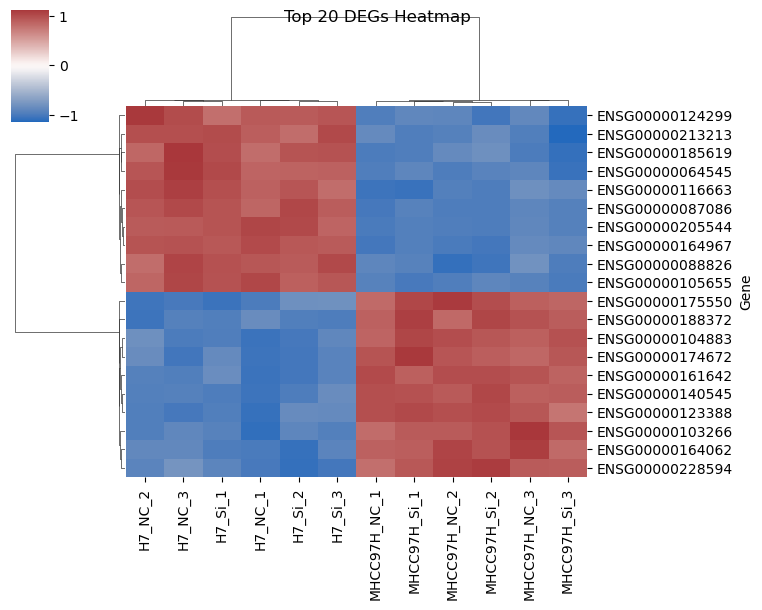

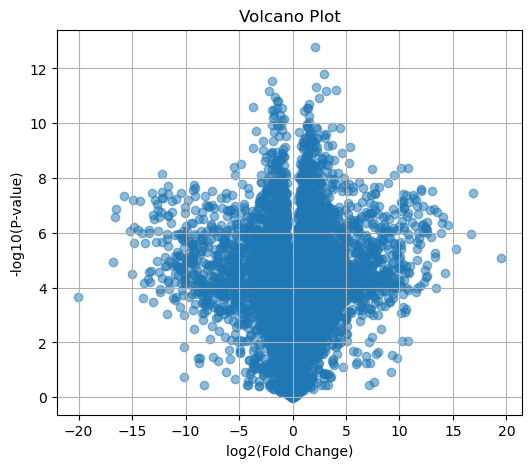

In [43]:
import tkinter as tk
from tkinter import filedialog, messagebox, Toplevel
import pandas as pd
import numpy as np
from scipy.stats import ttest_ind
from statsmodels.stats.multitest import multipletests
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from matplotlib.backends.backend_tkagg import FigureCanvasTkAgg

class DEGApp:
    def __init__(self, root):
        self.root = root
        self.root.title("Differential Expression Analyzer")
        self.root.geometry("500x650")
        self.root.configure(bg="#e6f2ff")

        self.file_path = None
        self.df = None

        tk.Label(root, text="Differential Expression Analyzer", font=("Arial", 16, "bold"), bg="#e6f2ff").pack(pady=15)
        tk.Button(root, text="Upload Gene Expression File", font=("Arial", 10), command=self.upload_file).pack(pady=10)

        tk.Label(root, text="Data Type:", bg="#e6f2ff").pack()
        self.data_type_var = tk.StringVar(value="TPM")
        tk.Radiobutton(root, text="TPM / Normalized", variable=self.data_type_var, value="TPM", bg="#e6f2ff").pack()
        tk.Radiobutton(root, text="Raw Count (DESeq2-like)", variable=self.data_type_var, value="Counts", bg="#e6f2ff").pack()

        tk.Label(root, text="Group 1 Samples (comma-separated):", bg="#e6f2ff").pack()
        self.group1_entry = tk.Entry(root, width=50)
        self.group1_entry.pack(pady=5)

        tk.Label(root, text="Group 2 Samples (comma-separated):", bg="#e6f2ff").pack()
        self.group2_entry = tk.Entry(root, width=50)
        self.group2_entry.pack(pady=5)

        tk.Label(root, text="P-value Threshold:", bg="#e6f2ff").pack()
        self.pvalue_entry = tk.Entry(root, width=10)
        self.pvalue_entry.insert(0, "0.05")
        self.pvalue_entry.pack(pady=5)

        tk.Label(root, text="Min abs(log2FC):", bg="#e6f2ff").pack()
        self.logfc_entry = tk.Entry(root, width=10)
        self.logfc_entry.insert(0, "1")
        self.logfc_entry.pack(pady=5)

        tk.Button(root, text="Find DEGs", font=("Arial", 10), bg="#4CAF50", fg="white", command=self.find_degs).pack(pady=20)

    def upload_file(self):
        self.file_path = filedialog.askopenfilename(
            initialdir=os.path.expanduser("~"),
            title="Select Gene Expression File",
            filetypes=[
                ("All Supported", "*.csv *.CSV *.tsv *.TSV *.txt *.TXT"),
                ("CSV files", "*.csv *.CSV"),
                ("TSV files", "*.tsv *.TSV"),
                ("Text files", "*.txt *.TXT"),
                ("All files", "*.*")
            ]
        )

        if self.file_path:
            try:
                if self.file_path.endswith(('.tsv', '.txt', '.TSV', '.TXT')):
                    self.df = pd.read_csv(self.file_path, sep='\t')
                else:
                    self.df = pd.read_csv(self.file_path)

                first_col = self.df.columns[0]
                if first_col != "Gene":
                    self.df.rename(columns={first_col: "Gene"}, inplace=True)

                if "Gene" not in self.df.columns:
                    messagebox.showerror("Error", "First column must contain gene names.")
                    return

                tk.Label(self.root, text=f"Loaded: {os.path.basename(self.file_path)}", bg="#e6f2ff", font=("Arial", 9, "italic")).pack()
                messagebox.showinfo("Success", f"File '{os.path.basename(self.file_path)}' loaded successfully.")

            except Exception as e:
                messagebox.showerror("File Error", str(e))

    def show_plot_popup(self, fig, title="Plot"):
        popup = Toplevel()
        popup.title(title)

        canvas = FigureCanvasTkAgg(fig, master=popup)
        canvas.draw()
        canvas.get_tk_widget().pack(fill=tk.BOTH, expand=True)

        def save_figure():
            file = filedialog.asksaveasfilename(defaultextension=".png", filetypes=[("PNG Image", "*.png"), ("All Files", "*.*")])
            if file:
                fig.savefig(file)
                messagebox.showinfo("Saved", f"Plot saved to: {file}")

        tk.Button(popup, text="Save Plot", command=save_figure).pack(pady=5)

    def find_degs(self):
        if self.df is None:
            messagebox.showerror("Error", "Please upload a dataset first.")
            return

        try:
            group1 = [col.strip() for col in self.group1_entry.get().split(",")]
            group2 = [col.strip() for col in self.group2_entry.get().split(",")]
            p_thresh = float(self.pvalue_entry.get())
            logfc_thresh = float(self.logfc_entry.get())
            data_type = self.data_type_var.get()

            gene_names = []
            p_values = []
            log2fcs = []

            data_subset = self.df["Gene"].to_frame().copy()
            data_subset[group1 + group2] = self.df[group1 + group2]

            if data_type == "TPM":
                data_subset = data_subset[(data_subset[group1 + group2].mean(axis=1)) > 1]
            elif data_type == "Counts":
                data_subset = data_subset[(data_subset[group1 + group2].sum(axis=1)) > 10]

            for idx, row in data_subset.iterrows():
                try:
                    g1_vals = row[group1].astype(float)
                    g2_vals = row[group2].astype(float)
                    stat, pval = ttest_ind(g1_vals, g2_vals, equal_var=False)

                    g1_mean = np.mean(g1_vals)
                    g2_mean = np.mean(g2_vals)
                    log2fc = np.log2(g2_mean / g1_mean) if g1_mean > 0 and g2_mean > 0 else np.nan

                    gene_names.append(row['Gene'])
                    p_values.append(pval)
                    log2fcs.append(log2fc)
                except Exception:
                    continue

            adj_pvals = multipletests(p_values, alpha=p_thresh, method='fdr_bh')[1]

            degs = pd.DataFrame({
                "Gene": gene_names,
                "log2FoldChange": log2fcs,
                "P-Value": p_values,
                "Adjusted P-Value": adj_pvals
            })

            degs_filtered = degs[(degs["Adjusted P-Value"] <= p_thresh) & (degs["log2FoldChange"].abs() >= logfc_thresh)]

            out_path = os.path.splitext(self.file_path)[0] + f"_DEGs_{data_type}.csv"
            degs_filtered.to_csv(out_path, index=False)
            messagebox.showinfo("DEGs Saved", f"{len(degs_filtered)} significant DEGs saved to {out_path}")

            # Volcano Plot in Popup
            fig1, ax1 = plt.subplots(figsize=(6, 5))
            ax1.scatter(degs['log2FoldChange'], -np.log10(degs['P-Value']), alpha=0.5)
            ax1.set_xlabel("log2(Fold Change)")
            ax1.set_ylabel("-log10(P-value)")
            ax1.set_title("Volcano Plot")
            ax1.grid(True)
            self.show_plot_popup(fig1, title="Volcano Plot")

            # Heatmap in Popup
            top_genes = degs_filtered.sort_values("Adjusted P-Value").head(20)["Gene"]
            heatmap_data = self.df.set_index("Gene").loc[top_genes, group1 + group2]
            cg = sns.clustermap(heatmap_data, cmap="vlag", z_score=0, figsize=(8, 6))
            cg.fig.suptitle("Top 20 DEGs Heatmap")
            self.show_plot_popup(cg.fig, title="Heatmap")

        except Exception as e:
            messagebox.showerror("Error", str(e))

if __name__ == "__main__":
    root = tk.Tk()
    app = DEGApp(root)
    root.mainloop()
